In [1]:
import numpy as np
import time 
import tensorflow as tf
import scipy.misc
%matplotlib inline
import matplotlib.pyplot as plt

## Loading a frozen graph

The following code shows how to load a frozen graph. The particular example is art style transfer in a feed-forward network, as descriped in https://arxiv.org/abs/1603.03417. In this network an image is transformed in a painting of a particular style in a single pass. The model has been taken from [here](http://dmitryulyanov.github.io/feed-forward-neural-doodle/) where you can also find more links concerning the theoretcal background. The transformation of the network from Lua to TensorFlow is part of an on going project thesis. A link explaining details will follow once the work is finished. 

In [11]:
# Downloading the model, if it does not exist
import urllib
import os
if not os.path.isfile('texture_net_frozen.pb'):
    urllib.urlretrieve(
    "https://dl.dropboxusercontent.com/u/9154523/models/texture_net/texture_net_frozen.pb",
    "texture_net_frozen.pb")
%ls -hl texture_net_frozen.pb

-rw-r--r--  1 oli  staff   6.4M Dec  2 10:39 texture_net_frozen.pb


We first load a content image, which we will feed through the network applying style transfer.

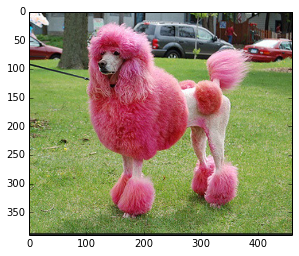

In [3]:
content_image = scipy.misc.imread('poodle.jpg')
plt.imshow(content_image)
content_image = content_image.astype(np.float)

### Loading from a frozen graph

The network including the weight has been frozen using the following code:
```
    graph = tf.get_default_graph()
    input_graph_def = graph.as_graph_def()
    from tensorflow.python.framework import graph_util
    # The output node names are used to determine which 
    # part of the graph needs to be frozen.
    output_node_names = "deprocessing/concat"
    output_graph_def = graph_util.convert_variables_to_constants(
            sess, # The session is used to retrieve the weights
            input_graph_def, # The graph_def is used to retrieve the nodes
            output_node_names.split(",") 
        )
    
    with tf.gfile.GFile('model/textur_net_frozen.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())
    print("%d ops in the final graph." % len(output_graph_def.node))
```

In [4]:
with tf.gfile.GFile('texture_net_frozen.pb', "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

In [5]:
tf.reset_default_graph()
graph = tf.Graph().as_default() 
tf.import_graph_def(graph_def,  name='')

In [6]:
# Finding the correct feeds and fetches
ops = tf.get_default_graph().get_operations()
#for i in ops[0:5]:
for i in ops[0:3]:
    print(i.name)
print('...')
for i in ops[-3:]:
    print(i.name)

image-placeholder
preprocessing/Div/y
preprocessing/Div
...
deprocessing/add_2
deprocessing/concat/concat_dim
deprocessing/concat


In [7]:
graph = tf.get_default_graph()
image = graph.get_tensor_by_name('image-placeholder:0')
fetch = graph.get_tensor_by_name('deprocessing/concat:0')

In [8]:
with tf.Session() as sess:
    t = time.time()
    res = sess.run(fetch, feed_dict={image:content_image})
    print("Transfer of {} pixels, done in {} sec".format(content_image.shape, time.time()-t))

Transfer of (390, 460, 3) pixels, done in 3.10594511032 sec


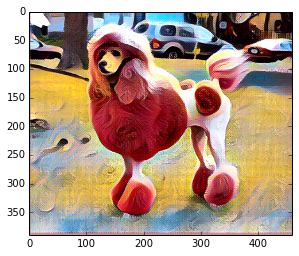

In [9]:
img = np.clip(res, 0, 255).astype(np.uint8)
#plt.figure(figsize=(126,8.0))
plt.figure()
plt.imshow(img)